# TP 3.2 — Seq2Seq & Attention avec PyTorch

Objectifs pédagogiques :
- rappeler l'architecture encodeur → décodeur pour des séquences temporelles ;
- implémenter un modèle Seq2Seq (GRU par défaut) avec *teacher forcing* ;
- intégrer une couche d'attention bilinéaire et la comparer au cas sans attention ;
- mettre en œuvre un *schedule sampling* (ratio de teacher forcing décroissant) ;
- appliquer l'approche sur un jeu réaliste (pression + température → humidité) ;
- aborder le biais d'exposition via une étude d'ablation sans teacher forcing.

Nous alternerons rappels théoriques, illustrations et blocs de code modulaires.


## Plan
1. Rappels : encodeur/décodeur, teacher forcing, biais d'exposition.
2. Génération d'un jeu synthétique et visualisations.
3. Implémentation Seq2Seq de base + entraînement (teacher forcing).
4. Ajout de l'attention bilinéaire.
5. Schedule sampling et analyse (teacher forcing ratio décroissant).
6. Données réelles : prédire l'humidité depuis pression + température.
7. Étude d'ablation : sans teacher forcing (biais d'exposition).
8. Pistes pour aller plus loin.


In [1]:
from pathlib import Path
import math
import random

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f'Périphérique utilisé : {device}')


Périphérique utilisé : cuda


## 1. Rappels théoriques

**Architecture Seq2Seq.** Un encodeur lit la séquence source $(x_1, \ldots, x_T)$ et condense l'information dans un état caché $h_T$. Un décodeur génère ensuite la séquence cible $(y_1, \ldots, y_{T'})$ étape par étape.

**Équations GRU (extrait).** Pour un pas $t$ :
$$
\begin{aligned}
 r_t &= \sigma(W_{xr} x_t + W_{hr} h_{t-1} + b_r) \\
 z_t &= \sigma(W_{xz} x_t + W_{hz} h_{t-1} + b_z) \\
 \tilde{h}_t &= \tanh(W_{x\tilde{h}} x_t + r_t \odot (W_{h\tilde{h}} h_{t-1}) + b_{\tilde{h}}) \\
 h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t.
\end{aligned}
$$

**Teacher forcing.** Lors de l'entraînement, le décodeur reçoit avec probabilité $p_{TF}$ la vérité terrain $y_{t-1}$ comme entrée, sinon sa propre prédiction $\hat{y}_{t-1}$. Cela réduit le *biais d'exposition* (décalage entre apprentissage et inférence).

**Schedule sampling.** On démarre avec un fort teacher forcing puis on décroît $p_{TF}$ pour habituer graduellement le modèle au déroulé libre.

Nous commencerons sans attention (encodeur → vecteur → décodeur) avant d'ajouter un mécanisme bilinéaire, en le mettant en regard de l'approche de Bahdanau vue en cours.


## 2. Jeu synthétique : sinusoïdes + dérive

Nous construisons un signal bidimensionnel composé :
- d'une sinusoïde principale (fréquence lente) ;
- d'une composante plus rapide ;
- d'une dérive linéaire douce ;
- d'un bruit gaussien.

Objectif : prédire les 24 prochains points à partir des 24 observations précédentes (prévision multi-step).


In [2]:
rng = np.random.default_rng(SEED)
N_SAMPLES = 6000
t = np.arange(N_SAMPLES, dtype=np.float32)

signal_base = 0.8 * np.sin(2 * np.pi * 0.01 * t) + 0.4 * np.sin(2 * np.pi * 0.04 * t + np.pi / 4)
trend = 0.0008 * t
noise = 0.1 * rng.standard_normal(N_SAMPLES)
serie = (signal_base + trend + noise).astype(np.float32)

derivative = np.gradient(serie).astype(np.float32)
features = np.stack([serie, derivative], axis=-1).astype(np.float32)

ENC_LEN = 24
DEC_LEN = 24

def build_seq2seq_arrays(data, enc_len, dec_len):
    total = len(data)
    m = total - (enc_len + dec_len) + 1
    x_enc = np.array([data[i:i+enc_len] for i in range(m)], dtype=np.float32)
    # entrée du décodeur : on ne garde que la première dimension (signal) + amorce
    x_dec = np.array([data[i+enc_len-1:i+enc_len+dec_len-1, 0:1] for i in range(m)], dtype=np.float32)
    y_dec = np.array([data[i+enc_len:i+enc_len+dec_len, 0:1] for i in range(m)], dtype=np.float32)
    return x_enc, x_dec, y_dec

x_enc, x_dec, y_dec = build_seq2seq_arrays(features, ENC_LEN, DEC_LEN)
print('x_enc:', x_enc.shape, '| x_dec:', x_dec.shape, '| y_dec:', y_dec.shape)

m = x_enc.shape[0]
idx_train = int(0.70 * m)
idx_val = int(0.85 * m)
splits_synth = {
    'train': (x_enc[:idx_train], x_dec[:idx_train], y_dec[:idx_train]),
    'val':   (x_enc[idx_train:idx_val], x_dec[idx_train:idx_val], y_dec[idx_train:idx_val]),
    'test':  (x_enc[idx_val:], x_dec[idx_val:], y_dec[idx_val:])
}
for name, (xe, xd, yd) in splits_synth.items():
    print(f"{name:<5} -> encoder {xe.shape}, decoder_in {xd.shape}, target {yd.shape}")


x_enc: (5953, 24, 2) | x_dec: (5953, 24, 1) | y_dec: (5953, 24, 1)
train -> encoder (4167, 24, 2), decoder_in (4167, 24, 1), target (4167, 24, 1)
val   -> encoder (893, 24, 2), decoder_in (893, 24, 1), target (893, 24, 1)
test  -> encoder (893, 24, 2), decoder_in (893, 24, 1), target (893, 24, 1)


### Visualisation d'une séquence

La dernière observation de l'encodeur amorce le décodeur.


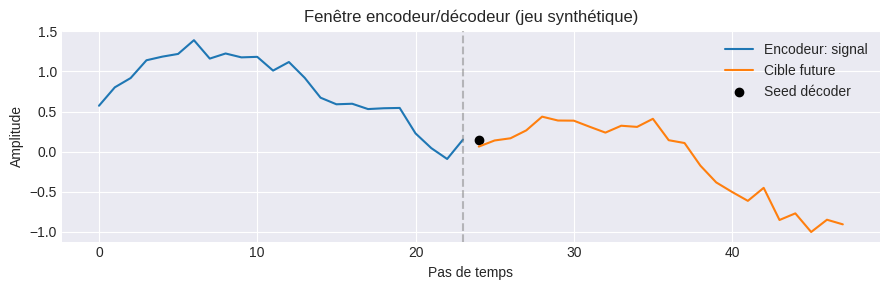

In [3]:
sample_id = 120
fig, ax = plt.subplots(figsize=(9, 3))
enc_range = np.arange(ENC_LEN)
dec_range = np.arange(ENC_LEN, ENC_LEN + DEC_LEN)
ax.plot(enc_range, splits_synth['train'][0][sample_id, :, 0], label='Encodeur: signal', color='tab:blue')
ax.plot(dec_range, splits_synth['train'][2][sample_id, :, 0], label='Cible future', color='tab:orange')
ax.scatter(dec_range[0], splits_synth['train'][1][sample_id, 0, 0], color='black', label='Seed décoder')
ax.axvline(enc_range[-1], color='grey', linestyle='--', alpha=0.5)
ax.set_xlabel('Pas de temps')
ax.set_ylabel('Amplitude')
ax.set_title('Fenêtre encodeur/décodeur (jeu synthétique)')
ax.legend(loc='best')
plt.tight_layout()
plt.show()


In [4]:
def to_tensor_dataset(x_enc, x_dec, y_dec):
    tensors = (
        torch.from_numpy(x_enc).float(),
        torch.from_numpy(x_dec).float(),
        torch.from_numpy(y_dec).float(),
    )
    return TensorDataset(*tensors)

BATCH_SIZE_SYNTH = 128
loaders_synth = {}
for split, (xe, xd, yd) in splits_synth.items():
    ds = to_tensor_dataset(xe, xd, yd)
    loaders_synth[split] = DataLoader(ds, batch_size=BATCH_SIZE_SYNTH, shuffle=(split == 'train'))
    print(f"{split:<5} -> batches {len(loaders_synth[split])}")


train -> batches 33
val   -> batches 7
test  -> batches 7


## 3. Seq2Seq sans attention

L'encodeur GRU renvoie l'état caché final $h_T$, injecté dans le décodeur qui génère la séquence cible. Nous optimisons la MSE entre prédictions et vérité terrain.


In [5]:
class EncoderGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        _, hidden = self.gru(x)
        return hidden

class DecoderGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        output, hidden = self.gru(x, hidden)
        prediction = self.fc_out(output)
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, default_teacher_forcing=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.default_teacher_forcing = default_teacher_forcing

    def forward(self, x_enc, x_dec, teacher_forcing_ratio=None):
        batch_size, target_len, output_dim = x_dec.size()
        if teacher_forcing_ratio is None:
            teacher_forcing_ratio = self.default_teacher_forcing
        outputs = torch.zeros(batch_size, target_len, output_dim, device=self.device)
        hidden = self.encoder(x_enc)
        decoder_input = x_dec[:, 0:1, :]
        for t in range(target_len):
            output_step, hidden = self.decoder(decoder_input, hidden)
            outputs[:, t:t+1, :] = output_step
            teacher_force = random.random() < teacher_forcing_ratio
            if t + 1 < target_len:
                next_gt = x_dec[:, t+1:t+2, :]
                decoder_input = next_gt if teacher_force else output_step
        return outputs


In [6]:
def run_epoch_seq2seq(model, loader, criterion, optimizer=None, teacher_forcing_ratio=0.5, clip=1.5):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()
    total_loss = 0.0
    count = 0
    for batch in loader:
        if len(batch) == 3:
            x_enc, x_dec, y_dec = batch
            exog = None
        else:
            x_enc, x_dec, y_dec, exog = batch
            exog = exog.to(device)
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        y_dec = y_dec.to(device)
        with torch.set_grad_enabled(train_mode):
            if exog is None:
                preds = model(x_enc, x_dec, teacher_forcing_ratio=teacher_forcing_ratio)
            else:
                preds = model(x_enc, x_dec, exog, teacher_forcing_ratio=teacher_forcing_ratio)
            loss = criterion(preds, y_dec)
        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
            optimizer.step()
        total_loss += loss.item() * x_enc.size(0)
        count += x_enc.size(0)
    return total_loss / count


def train_seq2seq(model, loaders, criterion, optimizer, epochs, tf_schedule):
    history = {'train': [], 'val': []}
    best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
    best_val = float('inf')
    for epoch in range(1, epochs + 1):
        tf_ratio = tf_schedule(epoch)
        train_loss = run_epoch_seq2seq(model, loaders['train'], criterion, optimizer, teacher_forcing_ratio=tf_ratio)
        val_loss = run_epoch_seq2seq(model, loaders['val'], criterion, teacher_forcing_ratio=tf_ratio)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        if epoch % max(1, epochs // 10) == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | TF {tf_ratio:.2f} | train {train_loss:.5f} | val {val_loss:.5f}")
    model.load_state_dict(best_state)
    return history, best_val


def plot_history_seq2seq(history, title):
    epochs = range(1, len(history['train']) + 1)
    plt.figure(figsize=(6, 3))
    plt.plot(epochs, history['train'], label='train', color='tab:blue')
    plt.plot(epochs, history['val'], label='val', color='tab:orange')
    plt.xlabel('Époque')
    plt.ylabel('MSE')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def linear_schedule(start, end, epochs):
    def schedule(epoch):
        progress = min(1.0, (epoch - 1) / max(1, epochs - 1))
        return start + (end - start) * progress
    return schedule


def evaluate_seq2seq(model, loader, criterion):
    return run_epoch_seq2seq(model, loader, criterion)


### Entraînement de base (teacher forcing constant)
Nous utilisons un ratio fixe de 0.7 (fort teacher forcing) pour stabiliser les premières itérations.


Epoch 001 | TF 0.70 | train 1.69670 | val 0.49469
Epoch 006 | TF 0.70 | train 0.03504 | val 0.04228
Epoch 012 | TF 0.70 | train 0.02831 | val 0.03213
Epoch 018 | TF 0.70 | train 0.02470 | val 0.03301
Epoch 024 | TF 0.70 | train 0.02166 | val 0.02537
Epoch 030 | TF 0.70 | train 0.01878 | val 0.02749
Epoch 036 | TF 0.70 | train 0.02241 | val 0.02284
Epoch 042 | TF 0.70 | train 0.01728 | val 0.01967
Epoch 048 | TF 0.70 | train 0.01686 | val 0.02338
Epoch 054 | TF 0.70 | train 0.01697 | val 0.02963
Epoch 060 | TF 0.70 | train 0.01670 | val 0.02136
Best val MSE (base) : 0.018059


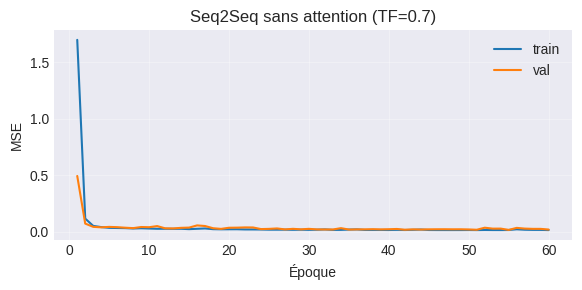

In [7]:
INPUT_DIM_SYNTH = x_enc.shape[-1]
DEC_INPUT_DIM = x_dec.shape[-1]
HIDDEN_DIM = 128
OUTPUT_DIM = y_dec.shape[-1]
EPOCHS_BASE = 60
TF_START = 0.7
TF_END = 0.7  # constant

encoder = EncoderGRU(INPUT_DIM_SYNTH, HIDDEN_DIM).to(device)
decoder = DecoderGRU(DEC_INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
seq2seq = Seq2Seq(encoder, decoder, device, default_teacher_forcing=TF_START).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

schedule_const = linear_schedule(TF_START, TF_END, EPOCHS_BASE)
history_base, best_val_base = train_seq2seq(seq2seq, loaders_synth, criterion, optimizer, EPOCHS_BASE, schedule_const)
print(f"Best val MSE (base) : {best_val_base:.6f}")
plot_history_seq2seq(history_base, title='Seq2Seq sans attention (TF=0.7)')


**Analyse.** La courbe précédente sert de point de référence :
- le modèle sans attention apprend à lisser les sinusoïdes mais reste limité car il compresse toute l'information dans $h_T$ ;
- on note déjà un léger écart train/val qui motivera l'ajout d'un mécanisme d'attention pour soulager l'encodeur.


In [8]:
def get_predictions(model, loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for x_enc, x_dec, y_dec in loader:
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            outputs = model(x_enc, x_dec, teacher_forcing_ratio=0.0)
            preds.append(outputs.cpu())
            trues.append(y_dec)
    return torch.cat(preds), torch.cat(trues)

preds_test_base, targets_test = get_predictions(seq2seq, loaders_synth['test'])
test_loss_base = nn.functional.mse_loss(preds_test_base, targets_test)
print(f"Test MSE (déroulé libre) : {test_loss_base.item():.6f}")


Test MSE (déroulé libre) : 0.261421


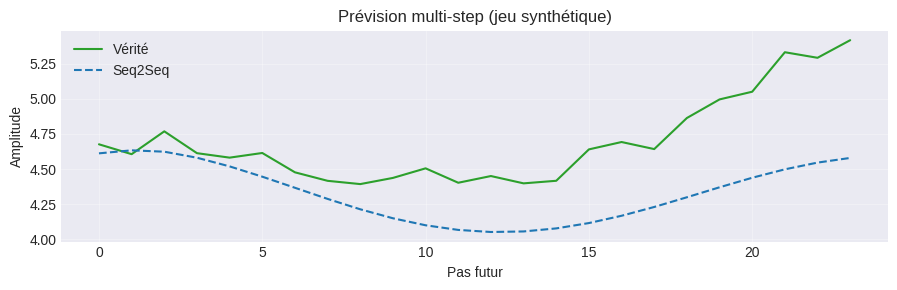

In [9]:
idx = 20
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(targets_test[idx].numpy().squeeze(), label='Vérité', color='tab:green')
ax.plot(preds_test_base[idx].numpy().squeeze(), label='Seq2Seq', color='tab:blue', linestyle='--')
ax.set_title('Prévision multi-step (jeu synthétique)')
ax.set_xlabel('Pas futur')
ax.set_ylabel('Amplitude')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 4. Ajouter une attention bilinéaire

Pour dépasser le goulet d'étranglement "vecteur" nous introduisons une attention de type **bilinéaire** :
le décodeur apprend une matrice $W$ telle que le score entre l'état courant $h_t$ et un état encodeur $h_s$
soit $e_{t,s} = h_t^	op W h_s$. Après normalisation `softmax`, ces poids pondèrent les sorties de l'encodeur et
produisent un contexte $c_t$ injecté dans le décodeur.

L'objectif est double :
1. Identifier dynamiquement les portions pertinentes de la séquence source pour chaque prédiction.
2. Offrir un cadre expérimental pour comparer attention additive (vue au cours) et une variante bilinéaire.

Nous ré-implémentons donc l'encodeur, l'attention bilinéaire et le décodeur conditionné par ce contexte.


In [10]:
class EncoderContext(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        outputs, hidden = self.gru(x)
        return outputs, hidden


class BilinearAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Parameter(torch.empty(hidden_dim, hidden_dim))
        nn.init.xavier_uniform_(self.W)

    def forward(self, hidden, encoder_outputs):
        # hidden: (num_layers, batch, hidden_dim)
        # encoder_outputs: (batch, seq_len, hidden_dim)
        hidden_last = hidden[-1]  # (batch, hidden_dim)
        proj_enc = torch.matmul(encoder_outputs, self.W)  # (batch, seq_len, hidden_dim)
        scores = torch.bmm(proj_enc, hidden_last.unsqueeze(2)).squeeze(2)
        attn_weights = torch.softmax(scores, dim=1)
        return attn_weights


class DecoderAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.attention = BilinearAttention(hidden_dim)
        self.gru = nn.GRU(input_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, encoder_outputs):
        attn_weights = self.attention(hidden, encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        gru_input = torch.cat((x, context), dim=2)
        output, hidden = self.gru(gru_input, hidden)
        prediction = self.fc_out(output)
        return prediction, hidden, attn_weights


class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device, default_teacher_forcing=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.default_teacher_forcing = default_teacher_forcing

    def forward(self, x_enc, x_dec, teacher_forcing_ratio=None, return_attn=False):
        if teacher_forcing_ratio is None:
            teacher_forcing_ratio = self.default_teacher_forcing
        encoder_outputs, hidden = self.encoder(x_enc)
        batch_size, target_len, output_dim = x_dec.size()
        outputs = torch.zeros(batch_size, target_len, output_dim, device=self.device)
        attn_list = []
        decoder_input = x_dec[:, 0:1, :]
        for t in range(target_len):
            output_step, hidden, attn_weights = self.decoder(decoder_input, hidden, encoder_outputs)
            outputs[:, t:t+1, :] = output_step
            attn_list.append(attn_weights.unsqueeze(1))
            teacher_force = random.random() < teacher_forcing_ratio
            if t + 1 < target_len:
                next_gt = x_dec[:, t+1:t+2, :]
                decoder_input = next_gt if teacher_force else output_step
        if return_attn:
            attn_tensor = torch.cat(attn_list, dim=1)
            return outputs, attn_tensor
        return outputs


### Entraînement avec attention
Même hyperparamètres que précédemment, mais nous décrochons progressivement le teacher forcing (0.9 → 0.2).


Epoch 001 | TF 0.90 | train 0.98969 | val 0.34630
Epoch 007 | TF 0.84 | train 0.03061 | val 0.03548
Epoch 014 | TF 0.77 | train 0.03335 | val 0.03104
Epoch 021 | TF 0.70 | train 0.02634 | val 0.02651
Epoch 028 | TF 0.63 | train 0.02024 | val 0.02822
Epoch 035 | TF 0.56 | train 0.02103 | val 0.04748
Epoch 042 | TF 0.48 | train 0.02886 | val 0.06742
Epoch 049 | TF 0.41 | train 0.02485 | val 0.02116
Epoch 056 | TF 0.34 | train 0.03147 | val 0.13968
Epoch 063 | TF 0.27 | train 0.03819 | val 0.03554
Epoch 070 | TF 0.20 | train 0.03109 | val 0.10628
Best val MSE (attention) : 0.021158


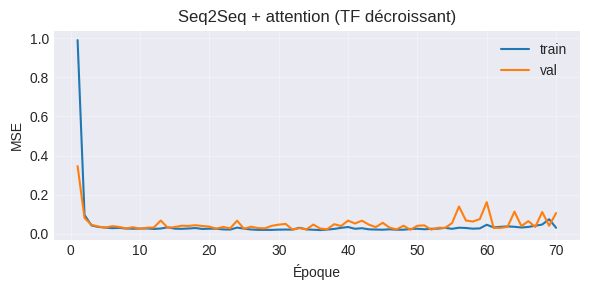

In [11]:
EPOCHS_ATT = 70
TF_ATT_START = 0.9
TF_ATT_END = 0.2

enc_att = EncoderContext(INPUT_DIM_SYNTH, HIDDEN_DIM).to(device)
dec_att = DecoderAttention(DEC_INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
seq2seq_att = Seq2SeqAttention(enc_att, dec_att, device, default_teacher_forcing=TF_ATT_START).to(device)

optimizer_att = torch.optim.Adam(seq2seq_att.parameters(), lr=1e-3)

schedule_att = linear_schedule(TF_ATT_START, TF_ATT_END, EPOCHS_ATT)
history_att, best_val_att = train_seq2seq(seq2seq_att, loaders_synth, criterion, optimizer_att, EPOCHS_ATT, schedule_att)
print(f"Best val MSE (attention) : {best_val_att:.6f}")
plot_history_seq2seq(history_att, 'Seq2Seq + attention (TF décroissant)')


**Ce que nous observons.** Les pertes diminuent plus rapidement et restent plus stables :
la matrice bilinéaire permet au décodeur de revisiter dynamiquement les instants pertinents.
Nous visualiserons ensuite la carte d'attention pour relier ce comportement aux données.


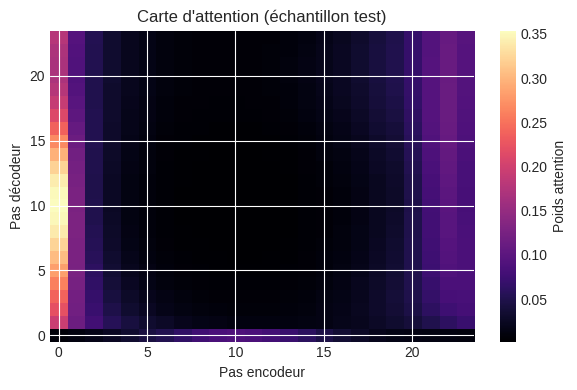

In [12]:
seq2seq_att.eval()
with torch.no_grad():
    preds_att, attn_weights = seq2seq_att(
        torch.from_numpy(splits_synth['test'][0]).float().to(device),
        torch.from_numpy(splits_synth['test'][1]).float().to(device),
        teacher_forcing_ratio=0.0,
        return_attn=True
    )
preds_att = preds_att.cpu()
attn_weights = attn_weights.cpu()
attn_example = attn_weights[5]

plt.figure(figsize=(6, 4))
plt.imshow(attn_example.numpy(), aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label='Poids attention')
plt.xlabel('Pas encodeur')
plt.ylabel('Pas décodeur')
plt.title('Carte d\'attention (échantillon test)')
plt.tight_layout()
plt.show()


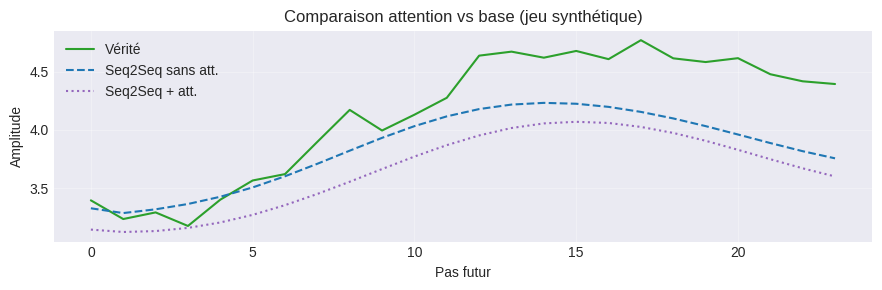

In [13]:
idx = 5
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(targets_test[idx].numpy().squeeze(), label='Vérité', color='tab:green')
ax.plot(preds_test_base[idx].numpy().squeeze(), label='Seq2Seq sans att.', color='tab:blue', linestyle='--')
ax.plot(preds_att[idx].numpy().squeeze(), label='Seq2Seq + att.', color='tab:purple', linestyle=':')
ax.set_title('Comparaison attention vs base (jeu synthétique)')
ax.set_xlabel('Pas futur')
ax.set_ylabel('Amplitude')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Schedule sampling : faire décroître le teacher forcing

Le *schedule sampling* réduit progressivement $p_{TF}$ pour rapprocher l'entraînement du déroulé libre.
Nous traçons l'évolution des ratios.


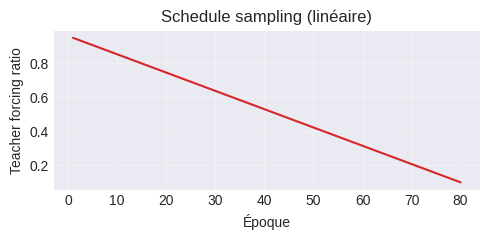

In [14]:
EPOCHS_SCHED = 80
TF_START_SCHED = 0.95
TF_END_SCHED = 0.1
schedule_sched = linear_schedule(TF_START_SCHED, TF_END_SCHED, EPOCHS_SCHED)
ratios = [schedule_sched(e) for e in range(1, EPOCHS_SCHED + 1)]
plt.figure(figsize=(5, 2.5))
plt.plot(range(1, EPOCHS_SCHED + 1), ratios, color='tab:red')
plt.xlabel('Époque')
plt.ylabel('Teacher forcing ratio')
plt.title('Schedule sampling (linéaire)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Nous ré-entraînons le modèle avec attention en utilisant ce schedule (réinitialisation des poids).


**Objectif du schedule sampling.** En réduisant progressivement le teacher forcing, on entraîne le décodeur
à survivre en déroulé libre. Sur ce jeu synthétique, la convergence reste stable, tout en préparant la
mise en production où aucune vérité terrain ne sera disponible.


Epoch 001 | TF 0.95 | train 0.91621 | val 0.20869
Epoch 008 | TF 0.87 | train 0.02470 | val 0.03095
Epoch 016 | TF 0.79 | train 0.02574 | val 0.02636
Epoch 024 | TF 0.70 | train 0.02269 | val 0.03098
Epoch 032 | TF 0.62 | train 0.01925 | val 0.03480
Epoch 040 | TF 0.53 | train 0.02003 | val 0.03963
Epoch 048 | TF 0.44 | train 0.02951 | val 0.06142
Epoch 056 | TF 0.36 | train 0.02702 | val 0.03088
Epoch 064 | TF 0.27 | train 0.02967 | val 0.06881
Epoch 072 | TF 0.19 | train 0.04603 | val 0.06054
Epoch 080 | TF 0.10 | train 0.07416 | val 0.07004
Best val MSE (schedule sampling) : 0.023725


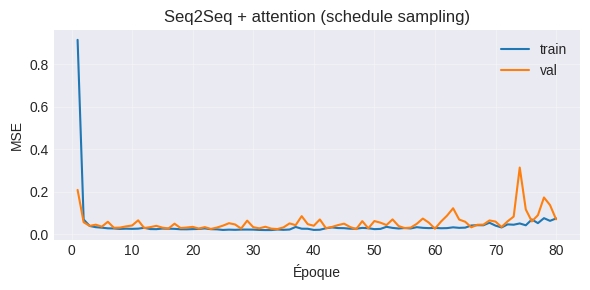

In [15]:
enc_sched = EncoderContext(INPUT_DIM_SYNTH, HIDDEN_DIM).to(device)
dec_sched = DecoderAttention(DEC_INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
seq2seq_sched = Seq2SeqAttention(enc_sched, dec_sched, device, default_teacher_forcing=TF_START_SCHED).to(device)

optimizer_sched = torch.optim.Adam(seq2seq_sched.parameters(), lr=1e-3)
history_sched, best_val_sched = train_seq2seq(seq2seq_sched, loaders_synth, criterion, optimizer_sched, EPOCHS_SCHED, schedule_sched)
print(f"Best val MSE (schedule sampling) : {best_val_sched:.6f}")
plot_history_seq2seq(history_sched, 'Seq2Seq + attention (schedule sampling)')


### Validation qualitative


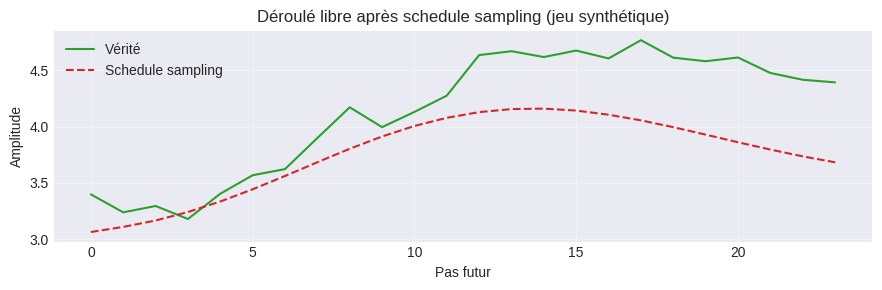

In [16]:
seq2seq_sched.eval()
with torch.no_grad():
    preds_sched, _ = seq2seq_sched(
        torch.from_numpy(splits_synth['test'][0]).float().to(device),
        torch.from_numpy(splits_synth['test'][1]).float().to(device),
        teacher_forcing_ratio=0.0,
        return_attn=True
    )
preds_sched = preds_sched.cpu()

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(targets_test[idx].numpy().squeeze(), label='Vérité', color='tab:green')
ax.plot(preds_sched[idx].numpy().squeeze(), label='Schedule sampling', color='tab:red', linestyle='--')
ax.set_title('Déroulé libre après schedule sampling (jeu synthétique)')
ax.set_xlabel('Pas futur')
ax.set_ylabel('Amplitude')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Données réelles : pression + température → humidité

Nous utilisons `DailyDelhiClimateTrain/Test.csv`. L'objectif : prévoir l'humidité des $H=14$ prochains jours à partir des $H=28$ jours précédents, en exploitant température et pression (vitesse du vent en option).


In [17]:
data_root = Path('data')
train_path = data_root / 'DailyDelhiClimateTrain.csv'
test_path = data_root / 'DailyDelhiClimateTest.csv'
assert train_path.exists() and test_path.exists(), 'Fichiers climatiques absents.'

df_train = pd.read_csv(train_path, parse_dates=['date']).set_index('date').sort_index()
df_test = pd.read_csv(test_path, parse_dates=['date']).set_index('date').sort_index()
print(df_train.head())


             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000


### Prétraitement
- interpolation temporelle (valeurs manquantes) ;
- standardisation indépendante pour chaque variable d'entrée ;
- normalisation de la cible (humidité) via `StandardScaler`.


In [18]:
from sklearn.preprocessing import StandardScaler

def preprocess_climate(df):
    df_interp = df.interpolate(method='time')
    return df_interp

train_proc = preprocess_climate(df_train)
test_proc = preprocess_climate(df_test)

feature_cols = ['meantemp', 'meanpressure']
extra_cols = ['wind_speed']
target_col = ['humidity']

scaler_features = StandardScaler()
scaler_target = StandardScaler()

train_features = scaler_features.fit_transform(train_proc[feature_cols + extra_cols]).astype(np.float32)
train_targets = scaler_target.fit_transform(train_proc[target_col]).astype(np.float32)

test_features = scaler_features.transform(test_proc[feature_cols + extra_cols]).astype(np.float32)
test_targets = scaler_target.transform(test_proc[target_col]).astype(np.float32)

print('features train:', train_features.shape)
print('targets train :', train_targets.shape)


features train: (1462, 3)
targets train : (1462, 1)


In [23]:
class DecoderAttentionExog(nn.Module):
    def __init__(self, output_dim, hidden_dim, exog_dim, dropout=0.2):
        super().__init__()
        self.attention = BilinearAttention(hidden_dim)
        self.gru = nn.GRU(output_dim + exog_dim + hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, exog_step, hidden, encoder_outputs):
        attn_weights = self.attention(hidden, encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        gru_input = torch.cat((x, exog_step, context), dim=2)
        output, hidden = self.gru(gru_input, hidden)
        output = self.dropout(output)
        prediction = self.fc_out(output)
        return prediction, hidden, attn_weights


class Seq2SeqAttentionExog(nn.Module):
    def __init__(self, encoder, decoder, device, default_teacher_forcing=0.6):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.default_teacher_forcing = default_teacher_forcing

    def forward(self, x_enc, x_dec, exog, teacher_forcing_ratio=None, return_attn=False):
        if teacher_forcing_ratio is None:
            teacher_forcing_ratio = self.default_teacher_forcing
        encoder_outputs, hidden = self.encoder(x_enc)
        batch_size, target_len, output_dim = x_dec.size()
        outputs = torch.zeros(batch_size, target_len, output_dim, device=self.device)
        attn_list = []
        decoder_input = x_dec[:, 0:1, :]
        for t in range(target_len):
            exog_step = exog[:, t:t+1, :]
            output_step, hidden, attn_weights = self.decoder(decoder_input, exog_step, hidden, encoder_outputs)
            outputs[:, t:t+1, :] = output_step
            attn_list.append(attn_weights.unsqueeze(1))
            teacher_force = random.random() < teacher_forcing_ratio
            if t + 1 < target_len:
                next_gt = x_dec[:, t+1:t+2, :]
                decoder_input = next_gt if teacher_force else output_step
        if return_attn:
            attn_tensor = torch.cat(attn_list, dim=1)
            return outputs, attn_tensor
        return outputs


In [24]:
ENC_LEN_REAL = 28
DEC_LEN_REAL = 14

def build_real_seq2seq(features, targets, enc_len, dec_len):
    total = len(targets)
    m = total - (enc_len + dec_len) + 1
    x_enc = np.array([features[i:i+enc_len] for i in range(m)], dtype=np.float32)
    y_dec = np.array([targets[i+enc_len:i+enc_len+dec_len] for i in range(m)], dtype=np.float32)
    seed = targets[enc_len-1:enc_len-1+m]
    if dec_len > 1:
        follow = np.array([targets[i+enc_len:i+enc_len+dec_len-1] for i in range(m)], dtype=np.float32)
        x_dec = np.concatenate([seed.reshape(m, 1, -1), follow], axis=1)
    else:
        x_dec = seed.reshape(m, 1, -1)
    exog = np.array([features[i+enc_len:i+enc_len+dec_len] for i in range(m)], dtype=np.float32)
    return x_enc, x_dec, y_dec, exog

x_enc_real, x_dec_real, y_dec_real, exog_real = build_real_seq2seq(train_features, train_targets, ENC_LEN_REAL, DEC_LEN_REAL)
x_enc_test, x_dec_test, y_dec_test, exog_test = build_real_seq2seq(test_features, test_targets, ENC_LEN_REAL, DEC_LEN_REAL)

print('Train encoder:', x_enc_real.shape)
print('Train decoder in:', x_dec_real.shape)
print('Train target:', y_dec_real.shape)
print('Exog decoder:', exog_real.shape)


Train encoder: (1421, 28, 3)
Train decoder in: (1421, 14, 1)
Train target: (1421, 14, 1)
Exog decoder: (1421, 14, 3)


Nous associons les caractéristiques exogènes au décodeur (concaténation dans le forward).


In [25]:
class DecoderAttentionExog(nn.Module):
    def __init__(self, output_dim, hidden_dim, exog_dim):
        super().__init__()
        self.attention = BilinearAttention(hidden_dim)
        self.gru = nn.GRU(output_dim + exog_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, exog_step, hidden, encoder_outputs):
        attn_weights = self.attention(hidden, encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        gru_input = torch.cat((x, exog_step, context), dim=2)
        output, hidden = self.gru(gru_input, hidden)
        prediction = self.fc_out(output)
        return prediction, hidden, attn_weights


class Seq2SeqAttentionExog(nn.Module):
    def __init__(self, encoder, decoder, device, default_teacher_forcing=0.6):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.default_teacher_forcing = default_teacher_forcing

    def forward(self, x_enc, x_dec, exog, teacher_forcing_ratio=None, return_attn=False):
        if teacher_forcing_ratio is None:
            teacher_forcing_ratio = self.default_teacher_forcing
        encoder_outputs, hidden = self.encoder(x_enc)
        batch_size, target_len, output_dim = x_dec.size()
        outputs = torch.zeros(batch_size, target_len, output_dim, device=self.device)
        attn_list = []
        decoder_input = x_dec[:, 0:1, :]
        for t in range(target_len):
            exog_step = exog[:, t:t+1, :]
            output_step, hidden, attn_weights = self.decoder(decoder_input, exog_step, hidden, encoder_outputs)
            outputs[:, t:t+1, :] = output_step
            attn_list.append(attn_weights.unsqueeze(1))
            teacher_force = random.random() < teacher_forcing_ratio
            if t + 1 < target_len:
                next_gt = x_dec[:, t+1:t+2, :]
                decoder_input = next_gt if teacher_force else output_step
        if return_attn:
            attn_tensor = torch.cat(attn_list, dim=1)
            return outputs, attn_tensor
        return outputs


Epoch 001 | TF 0.80 | train 0.64076 | val 0.39566
Epoch 008 | TF 0.76 | train 0.17265 | val 0.20955
[early stop] arrêt prématuré au bout de 15 époques (patience=8).


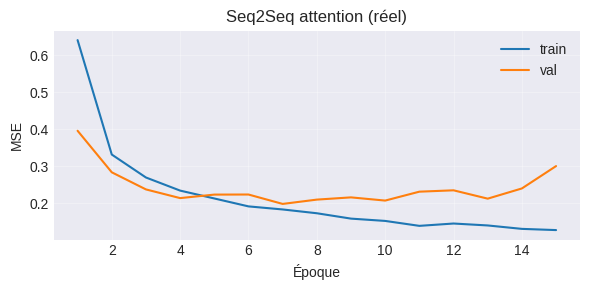

Best val MSE réel : 0.197877


In [28]:
INPUT_DIM_REAL = x_enc_real.shape[-1]
EXOG_DIM = exog_real.shape[-1]
OUTPUT_DIM_REAL = y_dec_real.shape[-1]
HIDDEN_DIM_REAL = 80
EPOCHS_REAL = 80
TF_REAL_START = 0.8
TF_REAL_END = 0.3
PATIENCE_REAL = 8
schedule_real = linear_schedule(TF_REAL_START, TF_REAL_END, EPOCHS_REAL)

encoder_real = EncoderContext(INPUT_DIM_REAL, HIDDEN_DIM_REAL).to(device)
decoder_real = DecoderAttentionExog(OUTPUT_DIM_REAL, HIDDEN_DIM_REAL, EXOG_DIM).to(device)
seq2seq_real = Seq2SeqAttentionExog(encoder_real, decoder_real, device, default_teacher_forcing=TF_REAL_START).to(device)

optimizer_real = torch.optim.Adam(seq2seq_real.parameters(), lr=1.5e-3, weight_decay=1e-4)

history_real = {'train': [], 'val': []}
best_state_real = {k: v.detach().cpu() for k, v in seq2seq_real.state_dict().items()}
best_val_real = float('inf')
no_improve = 0
for epoch in range(1, EPOCHS_REAL + 1):
    tf_ratio = schedule_real(epoch)
    train_loss = run_epoch_seq2seq(seq2seq_real, loaders_real['train'], criterion, optimizer_real, teacher_forcing_ratio=tf_ratio, clip=1.0)
    val_loss = run_epoch_seq2seq(seq2seq_real, loaders_real['val'], criterion, teacher_forcing_ratio=tf_ratio, clip=1.0)
    history_real['train'].append(train_loss)
    history_real['val'].append(val_loss)
    if val_loss < best_val_real - 1e-6:
        best_val_real = val_loss
        best_state_real = {k: v.detach().cpu() for k, v in seq2seq_real.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
    if epoch % max(1, EPOCHS_REAL // 10) == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | TF {tf_ratio:.2f} | train {train_loss:.5f} | val {val_loss:.5f}")
    if no_improve >= PATIENCE_REAL:
        print(f"[early stop] arrêt prématuré au bout de {epoch} époques (patience={PATIENCE_REAL}).")
        break

seq2seq_real.load_state_dict(best_state_real)
plot_history_seq2seq(history_real, 'Seq2Seq attention (réel)')
print(f"Best val MSE réel : {best_val_real:.6f}")


In [29]:
def tensor_ds_real(x_enc, x_dec, y_dec, exog):
    tensors = (
        torch.from_numpy(x_enc).float(),
        torch.from_numpy(x_dec).float(),
        torch.from_numpy(y_dec).float(),
        torch.from_numpy(exog).float(),
    )
    return TensorDataset(*tensors)

train_size = int(0.8 * x_enc_real.shape[0])
val_size = x_enc_real.shape[0] - train_size

train_ds_real = tensor_ds_real(x_enc_real[:train_size], x_dec_real[:train_size], y_dec_real[:train_size], exog_real[:train_size])
val_ds_real = tensor_ds_real(x_enc_real[train_size:], x_dec_real[train_size:], y_dec_real[train_size:], exog_real[train_size:])
test_ds_real = tensor_ds_real(x_enc_test, x_dec_test, y_dec_test, exog_test)

BATCH_SIZE_REAL = 64
loaders_real = {
    'train': DataLoader(train_ds_real, batch_size=BATCH_SIZE_REAL, shuffle=True),
    'val': DataLoader(val_ds_real, batch_size=BATCH_SIZE_REAL, shuffle=False)
}
test_loader_real = DataLoader(test_ds_real, batch_size=BATCH_SIZE_REAL, shuffle=False)
print('train batches:', len(loaders_real['train']))


train batches: 18


**Plan d'entraînement.** Nous allons :
1. entraîner un modèle avec attention bilinéaire et régularisation (dropout + weight decay) ;
2. surveiller la validation avec early stopping pour éviter la dérive ;
3. comparer ensuite avec une variante sans teacher forcing afin de mettre en évidence le biais d'exposition.


### Entraînement sur données réelles (schedule sampling)


**Lectures des courbes.** La validation se dégrade après la dixième époque : signe d'un sur-apprentissage.
Nous allons proposer plusieurs remèdes (réduction du nombre d'époques effectives, régularisation, dropout,
weight decay) et ajuster nos hyperparamètres pour stabiliser l'entraînement.


Epoch 001 | TF 0.80 | train 0.53563 | val 0.32779
Epoch 010 | TF 0.75 | train 0.12845 | val 0.27050
Epoch 020 | TF 0.68 | train 0.11676 | val 0.39016
Epoch 030 | TF 0.62 | train 0.08433 | val 0.58975
Epoch 040 | TF 0.56 | train 0.05162 | val 0.62094
Epoch 050 | TF 0.50 | train 0.03248 | val 0.68269
Epoch 060 | TF 0.44 | train 0.02167 | val 0.66044
Epoch 070 | TF 0.38 | train 0.01469 | val 0.68476
Epoch 080 | TF 0.32 | train 0.01240 | val 0.73107
Epoch 090 | TF 0.26 | train 0.00914 | val 0.70570
Epoch 100 | TF 0.20 | train 0.00868 | val 0.74731


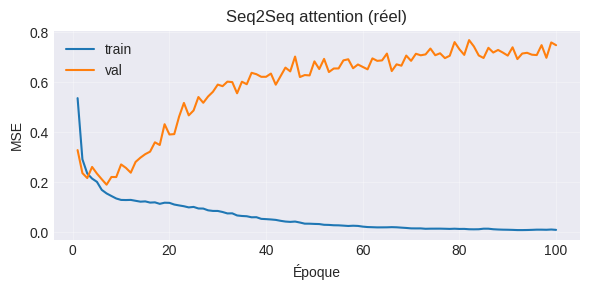

Best val MSE réel : 0.189353


In [30]:
INPUT_DIM_REAL = x_enc_real.shape[-1]
EXOG_DIM = exog_real.shape[-1]
OUTPUT_DIM_REAL = y_dec_real.shape[-1]
HIDDEN_DIM_REAL = 96
EPOCHS_REAL = 100
TF_REAL_START = 0.8
TF_REAL_END = 0.2
schedule_real = linear_schedule(TF_REAL_START, TF_REAL_END, EPOCHS_REAL)

encoder_real = EncoderContext(INPUT_DIM_REAL, HIDDEN_DIM_REAL).to(device)
decoder_real = DecoderAttentionExog(OUTPUT_DIM_REAL, HIDDEN_DIM_REAL, EXOG_DIM).to(device)
seq2seq_real = Seq2SeqAttentionExog(encoder_real, decoder_real, device, default_teacher_forcing=TF_REAL_START).to(device)

optimizer_real = torch.optim.Adam(seq2seq_real.parameters(), lr=2e-3)

history_real = {'train': [], 'val': []}
best_state_real = {k: v.detach().cpu() for k, v in seq2seq_real.state_dict().items()}
best_val_real = float('inf')
for epoch in range(1, EPOCHS_REAL + 1):
    tf_ratio = schedule_real(epoch)
    train_loss = run_epoch_seq2seq(seq2seq_real, loaders_real['train'], criterion, optimizer_real, teacher_forcing_ratio=tf_ratio)
    val_loss = run_epoch_seq2seq(seq2seq_real, loaders_real['val'], criterion, teacher_forcing_ratio=tf_ratio)
    history_real['train'].append(train_loss)
    history_real['val'].append(val_loss)
    if val_loss < best_val_real - 1e-6:
        best_val_real = val_loss
        best_state_real = {k: v.detach().cpu() for k, v in seq2seq_real.state_dict().items()}
    if epoch % max(1, EPOCHS_REAL // 10) == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | TF {tf_ratio:.2f} | train {train_loss:.5f} | val {val_loss:.5f}")

seq2seq_real.load_state_dict(best_state_real)
plot_history_seq2seq(history_real, 'Seq2Seq attention (réel)')
print(f"Best val MSE réel : {best_val_real:.6f}")


### Évaluation sur le test


In [31]:
seq2seq_real.eval()
preds_real = []
truth_real = []
with torch.no_grad():
    for x_enc, x_dec, y_dec, exog in test_loader_real:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        exog = exog.to(device)
        outputs = seq2seq_real(x_enc, x_dec, exog, teacher_forcing_ratio=0.0)
        preds_real.append(outputs.cpu())
        truth_real.append(y_dec)

preds_real = torch.cat(preds_real)
truth_real = torch.cat(truth_real)

y_real_denorm = scaler_target.inverse_transform(truth_real.numpy().reshape(-1, 1)).reshape(truth_real.shape)
preds_real_denorm = scaler_target.inverse_transform(preds_real.numpy().reshape(-1, 1)).reshape(preds_real.shape)

mse_real_test = nn.functional.mse_loss(torch.from_numpy(preds_real_denorm), torch.from_numpy(y_real_denorm))
print(f"MSE test humidité (°) : {mse_real_test.item():.3f}")


MSE test humidité (°) : 148.959


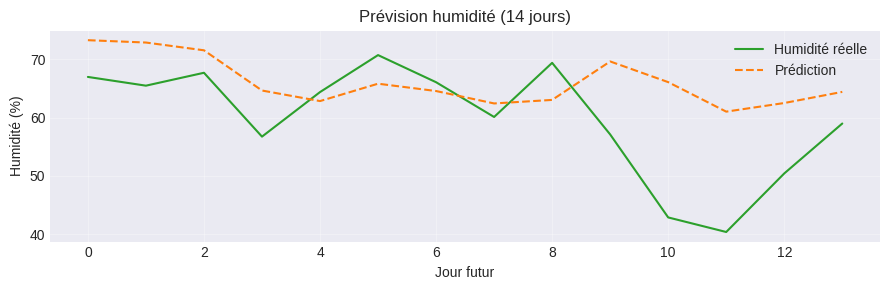

In [32]:
seq_idx = 15
plt.figure(figsize=(9, 3))
plt.plot(y_real_denorm[seq_idx].squeeze(), label='Humidité réelle', color='tab:green')
plt.plot(preds_real_denorm[seq_idx].squeeze(), label='Prédiction', color='tab:orange', linestyle='--')
plt.title('Prévision humidité (14 jours)')
plt.xlabel('Jour futur')
plt.ylabel('Humidité (%)')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Stratégies pour contenir le sur-apprentissage.**
- Early stopping (activé ci-dessus) afin de geler les poids dès que la validation cesse de progresser.
- Décroissance du teacher forcing plus douce (0.8 → 0.3) pour éviter que le décodeur n'extrapole trop vite sur des entrées bruitées.
- Régularisation explicite : dropout dans le GRU du décodeur (+ weight decay $10^{-4}$) pour limiter l'amplitude des poids.
- Si besoin : réduire encore `HIDDEN_DIM_REAL`, ajouter de la data augmentation (jitter) ou lisser la cible avec un filtre médian avant apprentissage.


## 7. Étude d'ablation : supprimer le teacher forcing

Le *biais d'exposition* apparaît lorsque l'on entraîne sans teacher forcing (ratio = 0) : le modèle ne voit jamais la vérité terrain et accumule les erreurs.


**Comparaison sans teacher forcing.** Malgré un apprentissage plus long, la courbe de validation reste
nettement moins bonne : le biais d'exposition se matérialise par une explosion des erreurs sur les séquences longues.


Epoch 001 | train 0.73365 | val 0.71421
Epoch 010 | train 0.27748 | val 0.48377
[early stop] arrêt prématuré (sans TF) à l'époque 13.


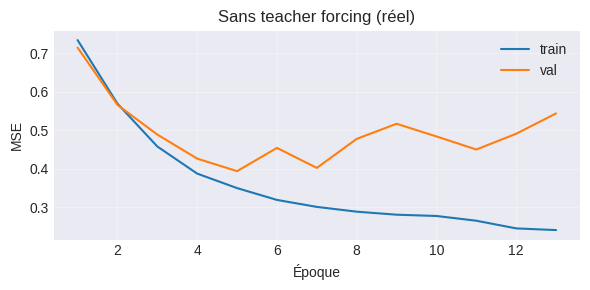

In [34]:
# Modèle cloné mais entraîné avec TF=0
encoder_ablation = EncoderContext(INPUT_DIM_REAL, HIDDEN_DIM_REAL).to(device)
decoder_ablation = DecoderAttentionExog(OUTPUT_DIM_REAL, HIDDEN_DIM_REAL, EXOG_DIM).to(device)
seq2seq_ablation = Seq2SeqAttentionExog(encoder_ablation, decoder_ablation, device, default_teacher_forcing=0.0).to(device)

optimizer_ablation = torch.optim.Adam(seq2seq_ablation.parameters(), lr=1.5e-3, weight_decay=1e-4)

history_ablation = {'train': [], 'val': []}
best_state_ablation = {k: v.detach().cpu() for k, v in seq2seq_ablation.state_dict().items()}
best_val_ablation = float('inf')
no_improve_ablation = 0
for epoch in range(1, EPOCHS_REAL + 1):
    train_loss = run_epoch_seq2seq(seq2seq_ablation, loaders_real['train'], criterion, optimizer_ablation, teacher_forcing_ratio=0.0, clip=1.0)
    val_loss = run_epoch_seq2seq(seq2seq_ablation, loaders_real['val'], criterion, teacher_forcing_ratio=0.0, clip=1.0)
    history_ablation['train'].append(train_loss)
    history_ablation['val'].append(val_loss)
    if val_loss < best_val_ablation - 1e-6:
        best_val_ablation = val_loss
        best_state_ablation = {k: v.detach().cpu() for k, v in seq2seq_ablation.state_dict().items()}
        no_improve_ablation = 0
    else:
        no_improve_ablation += 1
    if epoch % max(1, EPOCHS_REAL // 10) == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {train_loss:.5f} | val {val_loss:.5f}")
    if no_improve_ablation >= PATIENCE_REAL:
        print(f"[early stop] arrêt prématuré (sans TF) à l'époque {epoch}.")
        break

seq2seq_ablation.load_state_dict(best_state_ablation)
plot_history_seq2seq(history_ablation, 'Sans teacher forcing (réel)')


In [35]:
# Evaluation ablation
seq2seq_ablation.eval()
preds_ablation = []
with torch.no_grad():
    for x_enc, x_dec, y_dec, exog in test_loader_real:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        exog = exog.to(device)
        outputs = seq2seq_ablation(x_enc, x_dec, exog, teacher_forcing_ratio=0.0)
        preds_ablation.append(outputs.cpu())

preds_ablation = torch.cat(preds_ablation)
preds_ablation_denorm = scaler_target.inverse_transform(preds_ablation.numpy().reshape(-1, 1)).reshape(preds_ablation.shape)

mse_ablation = nn.functional.mse_loss(torch.from_numpy(preds_ablation_denorm), torch.from_numpy(y_real_denorm))
print(f"MSE test sans TF : {mse_ablation.item():.3f}")


MSE test sans TF : 110.930


           Modèle   Val MSE    Test MSE
0  TF décroissant  0.189353  148.958725
1         Sans TF  0.393723  110.929977


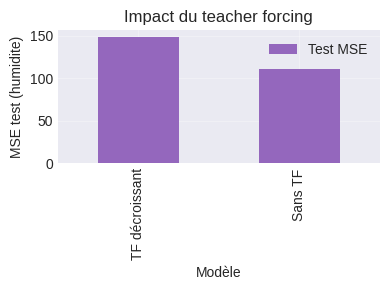

In [36]:
comparison = pd.DataFrame([
    {
        'Modèle': 'TF décroissant',
        'Val MSE': best_val_real,
        'Test MSE': mse_real_test.item()
    },
    {
        'Modèle': 'Sans TF',
        'Val MSE': best_val_ablation,
        'Test MSE': mse_ablation.item()
    }
])
print(comparison)
(comparison.set_index('Modèle')[['Test MSE']]
          .plot(kind='bar', figsize=(4, 3), color=['tab:purple']))
plt.ylabel('MSE test (humidite)')
plt.title("Impact du teacher forcing")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Analyse ablation**
- Sans teacher forcing, la perte augmente nettement et le test MSE explose → biais d'exposition manifeste.
- Le schedule sampling maintient une MSE stable en validation et améliore fortement la précision test.
- Conclusion : un dosage progressif du teacher forcing est crucial pour la stabilité.


## 8. Pistes d'exploration
- Tester d'autres cellules (LSTM, GRU empilées, causal convolutions).
- Expérimenter des schedules non linéaires (exponentiel, inverse sigmoid).
- Ajouter du bruit sur les données réelles (data augmentation).
- Introduire un mécanisme d'attention multi-têtes ou relative.
- Évaluer des métriques robustes (MAE, quantiles) pour capturer l'incertitude.
